In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_corr
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


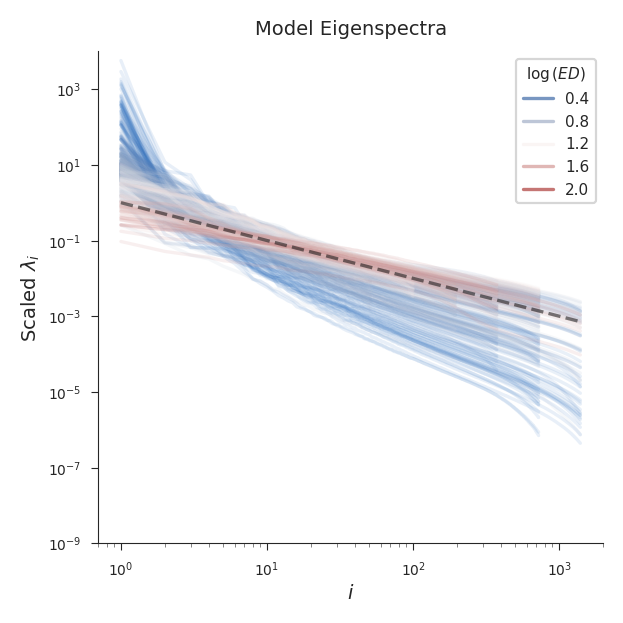

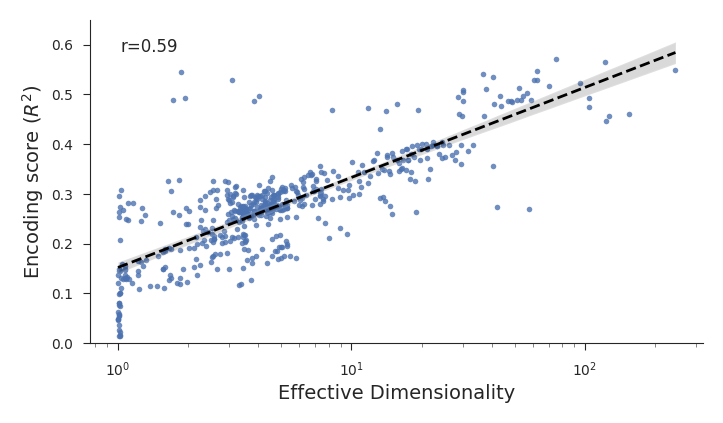

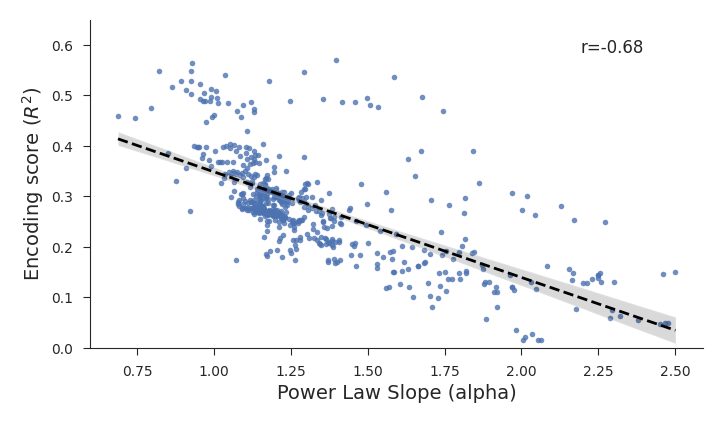

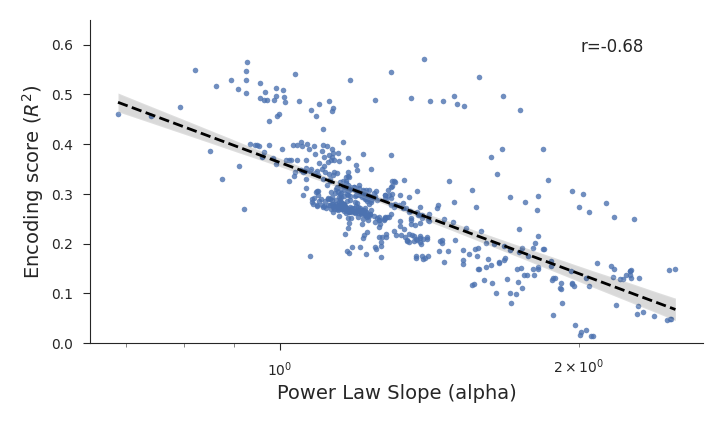

-0.7037898007336608


In [4]:
#Eric's plot
# - pearson r computed with ED and score
# - plotted with ED in log scale and a linear fit to logED vs score
#   - plotting in logx shows the points in a clearer way, and computing the linear fit line in with logx keeps it appearing linear
#   - but, pearson r for ED vs score (not logED) is reported because that is what we're more interested in (I guess)

#from plotting import annotate_corr

dataset = 'imagenet'


data = pd.merge(pd.read_csv(f'../../../results_marcc/reproductions/eigspectra|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                pd.read_csv(f'../../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Model Eigenspectra')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


#_Enoding score_
data = pd.merge(pd.read_csv(f'../../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

#___no logs___
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective Dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#alpha
data = pd.merge(pd.read_csv(f'../../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)


#___no logs___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)')
ax.text(.8, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#___original___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.8, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


data['log_alpha'] = np.log10(data['alpha'])
r, p = sp.stats.pearsonr(data['log_alpha'], data['score'])
print(r)

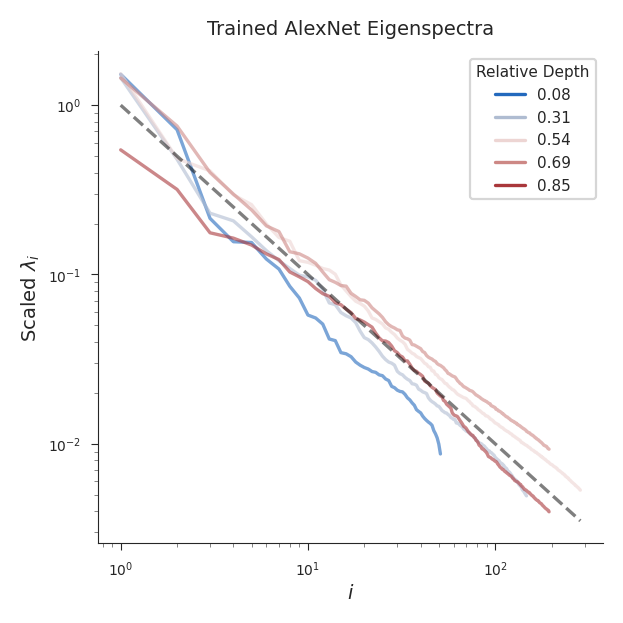

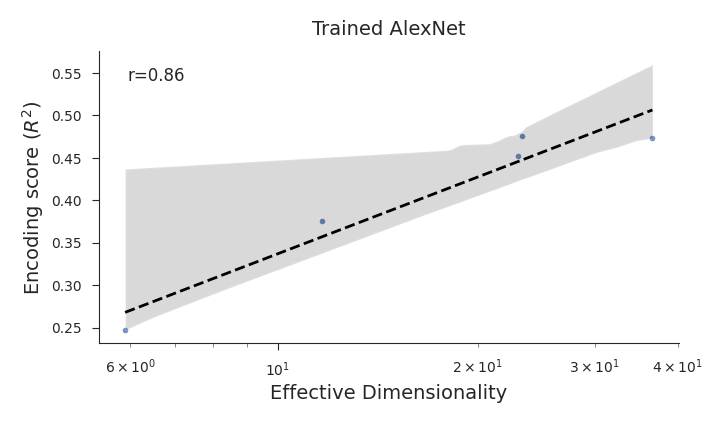

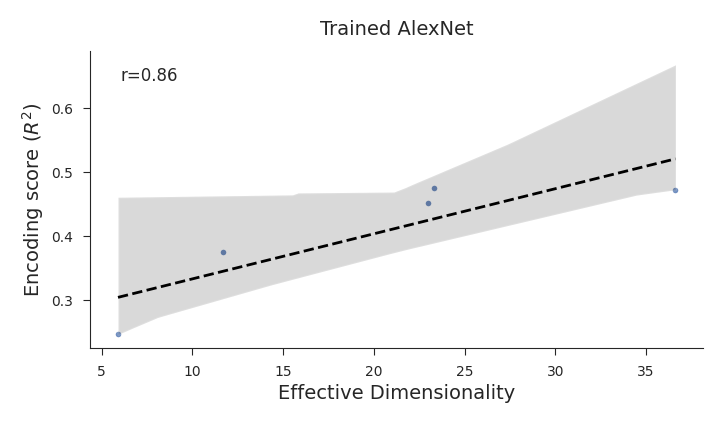

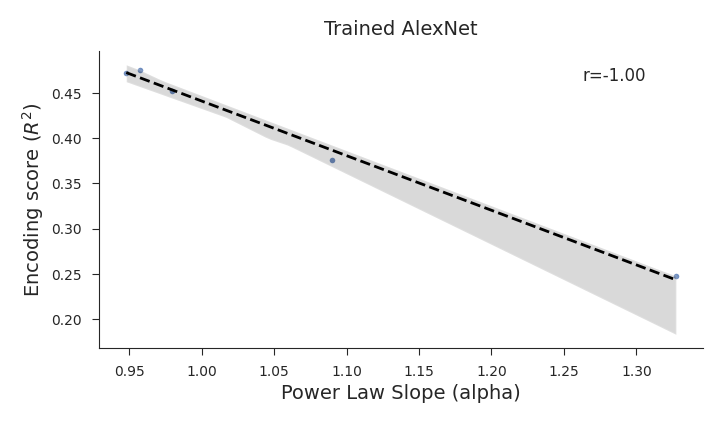

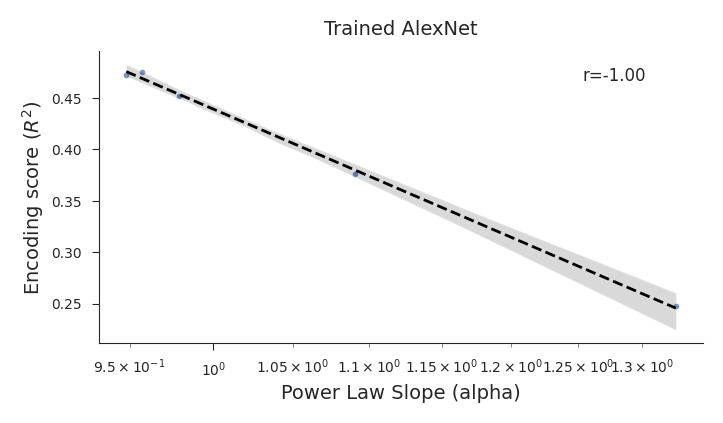

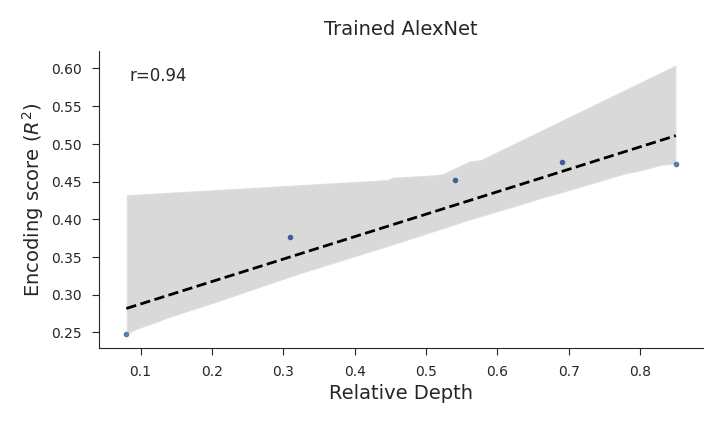

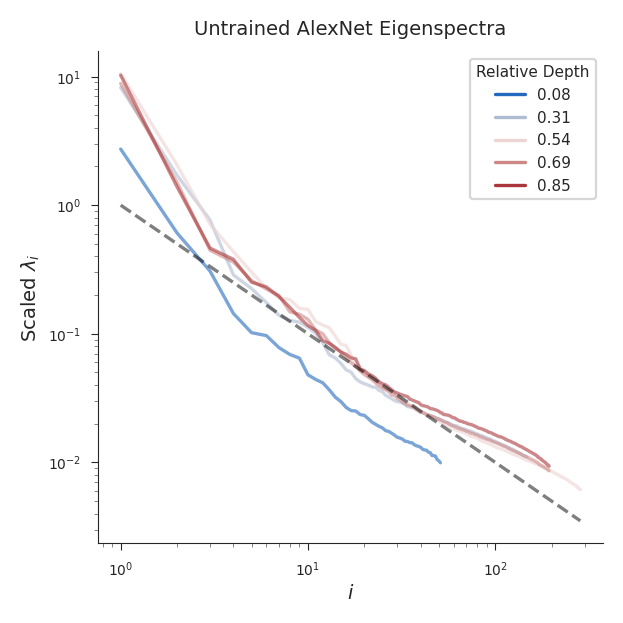

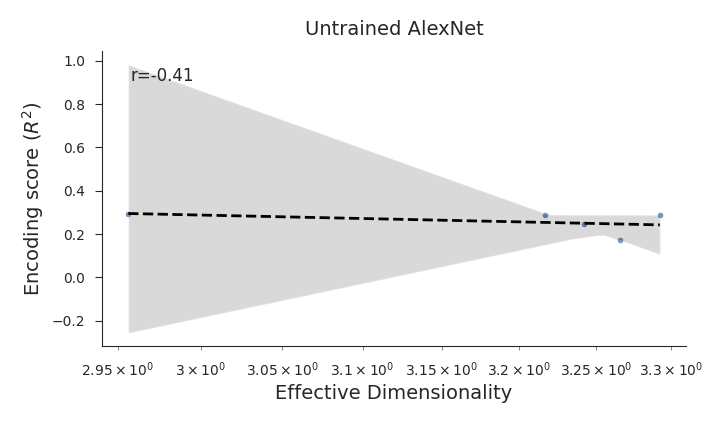

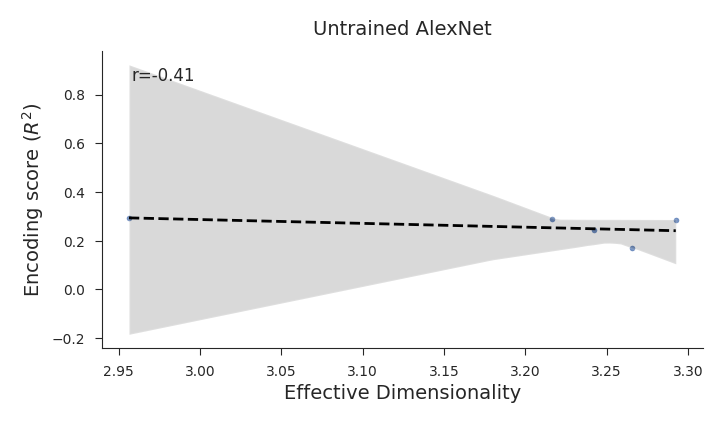

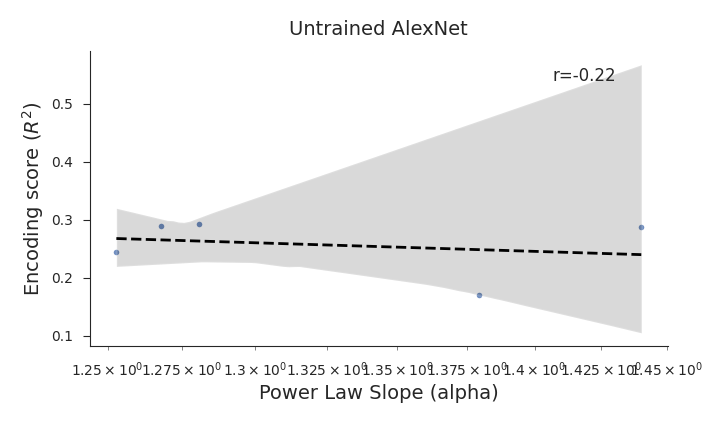

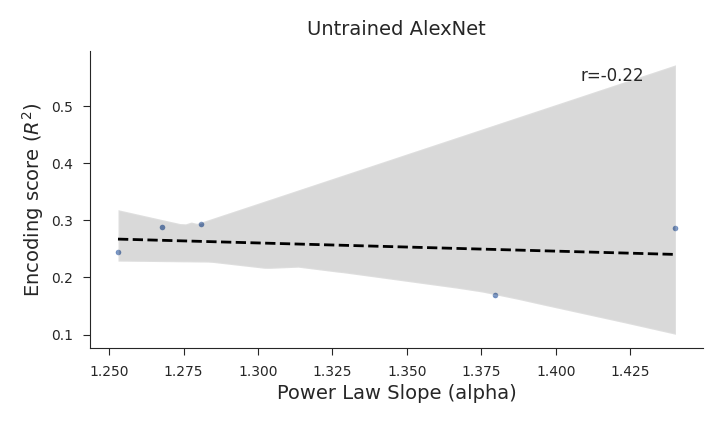

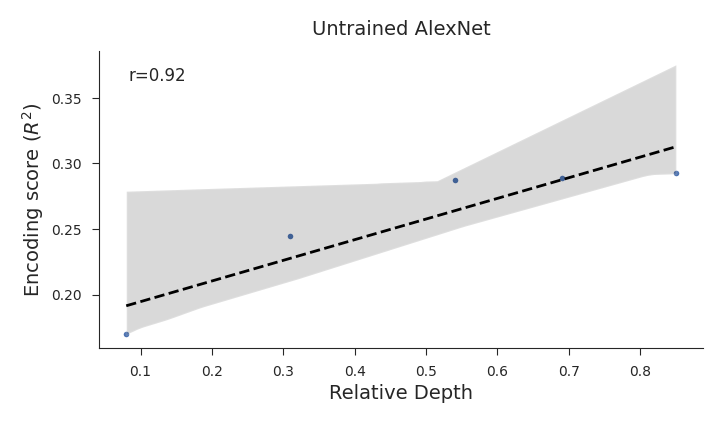

In [8]:
#Layer depth
# - x and y limits?

dataset = 'imagenet'
pooling = 'max'
model = 'AlexNet'
model_depth = 13
# - model_depth=8? (if no relu)

#____Trained____

metrics = pd.read_csv(f'../../../results_marcc/untrained/eigmetrics_pytrch|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
metrics = metrics[ (metrics['architecture'] == model)]
spectra = pd.read_csv(f'../../../results_marcc/untrained/eigspectra_pytrch|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
spectra = spectra[ (spectra['architecture'] == model)]

data = pd.merge(metrics, spectra, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#__Eigenspectrum__

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
#data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='layer_depth',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Trained AlexNet Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'Relative Depth')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


#__Encoding Score__
encoding = pd.read_csv(f'../../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
enoding = encoding[ (encoding['architecture'] == model)]
encoding = encoding[ (encoding['kind'] == 'Supervised')]
data = pd.merge(metrics, encoding, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#_Effective dimensionality_
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
#r = 0.86 (logx=false, no x_scale = 'log)

#___log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective Dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Trained AlexNet')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#___no log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective Dimensionality', ylabel=r'Encoding score ($R^2$)', title='Trained AlexNet')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#_alpha_
#___no logs___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
#custom_palette = sns.diverging_palette(h_neg=220, h_pos=20, sep=1, n=len(data['layer_depth']) )#, as_cmap=True)
sns.regplot(data=data, x='alpha', y='score',
            logx=False,
            #scatter_kws={'alpha': 1, 's': 6, 'linewidth': 0.2, 'edgecolors': 'black', 'facecolors': custom_palette }, 
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, #'alpha': 0.8
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Trained AlexNet')
ax.text(.8, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#___logs___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
#custom_palette = sns.diverging_palette(h_neg=220, h_pos=20, sep=1, n=len(data['layer_depth']) )#, as_cmap=True)
sns.regplot(data=data, x='alpha', y='score',
            logx=True,
            #scatter_kws={'alpha': 1, 's': 6, 'linewidth': 0.2, 'edgecolors': 'black', 'facecolors': custom_palette }, 
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, #'alpha': 0.8
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Trained AlexNet')
ax.text(.8, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#_Relative depth_
r, p = sp.stats.pearsonr(data['layer_depth'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative Depth', ylabel=r'Encoding score ($R^2$)', title='Trained AlexNet')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#____Untrained____

metrics = pd.read_csv(f'../../../results_marcc/untrained/eigmetrics_unt|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
metrics = metrics[ (metrics['architecture'] == model)]
spectra = pd.read_csv(f'../../../results_marcc/untrained/eigspectra_unt|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
spectra = spectra[ (spectra['architecture'] == model)]

data = pd.merge(metrics, spectra, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#__Eigenspectrum__
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var


fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='layer_depth',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Untrained AlexNet Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'Relative Depth')
plt.show()


#__Encoding Score__
encoding = pd.read_csv(f'../../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
enoding = encoding[ (encoding['architecture'] == model)]
encoding = encoding[ (encoding['kind'] == 'Untrained')]
data = pd.merge(metrics, encoding, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#_Effective dimensionality_
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

#___log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective Dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Untrained AlexNet')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#___no log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective Dimensionality', ylabel=r'Encoding score ($R^2$)', title='Untrained AlexNet')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#_alpha_
r, p = sp.stats.pearsonr(data['alpha'], data['score'])

#___log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
#custom_palette = sns.diverging_palette(h_neg=220, h_pos=20, sep=1, n=len(data['layer_depth']) )#, as_cmap=True)
sns.regplot(data=data, x='alpha', y='score',
            logx=True,
            #scatter_kws={'alpha': 1, 's': 6, 'linewidth': 0.2, 'edgecolors': 'black', 'facecolors': custom_palette }, 
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, #'alpha': 0.8
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Untrained AlexNet')
ax.text(.8, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#___no log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score',
            logx=False,
            #scatter_kws={'alpha': 1, 's': 6, 'linewidth': 0.2, 'edgecolors': 'black', 'facecolors': custom_palette }, 
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, #'alpha': 0.8
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Untrained AlexNet')
ax.text(.8, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#_Relative depth_
r, p = sp.stats.pearsonr(data['layer_depth'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative Depth', ylabel=r'Encoding score ($R^2$)', title='Untrained AlexNet')#, xscale='log')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

In [ ]:
#Init Method:
#***missing normal, uni (but unt is normal with stdev~0.5)
# - *plot with AtlasNet instead?


model = 'AlexNet'
pooling = 'max'
inits = ['unt','KaiUni', 'O']

data_s = pd.DataFrame()
for init in inits:
    dm = pd.read_csv(f'../../../results_marcc/untrained/eigmetrics_{init}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
    dm = dm[ (dm['architecture'] == model)]
    ds = pd.read_csv(f'../../../results_marcc/untrained/eigspectra_{init}|dataset:imagenet|pooling:{pooling}|grayscale:False.csv')
    ds = ds[ (ds['architecture'] == model)]
    if init == 'unt':
        data_m = dm
        data_s = ds
    else:
       data_m = pd.concat([data_m, dm], ignore_index=True)
       data_s = pd.concat([data_s, ds], ignore_index=True)
        
data = pd.merge(data_m, data_s, on=id_columns)
data['id'] = data[id_columns].sum(axis='columns')

layers = data.layer.unique()
for layer in layers:
    data_l = data[ (data['layer'] == layer)]
    
# Remove outlier low-variance points at the final PCs
    def is_outlier(i):
        i = np.log(i)
        cutoff = 0.95 * i.iloc[-1]
        return i > cutoff
    outlier = data_l.groupby(id_columns)['n'].transform(is_outlier)
    data_l = data_l[~outlier]

# Set y-intercept to 1
    def get_scaled_var(x):
        i, y = x['n'].values, x['variance'].values
        i, y = np.log(i), np.log(y)
        intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
        intercept = np.exp(intercept)
        return x['variance'] / intercept
    scaled_var = data_l.groupby(id_columns).apply(get_scaled_var)
    scaled_var = scaled_var.reset_index(id_columns, drop=True)
    data_l['scaled_variance'] = scaled_var

# Log(ED)
    data_l['log_ed'] = np.log10(data_l['effective dimensionality'])

    fig, ax = plt.subplots(figsize=(3, 3))

    sns.lineplot(data=data_l, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
    ax.plot([1, data_l.n.max()], [1, 1 / data_l.n.max()], linestyle='--', color='black', alpha=0.5)
    ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=f'AlexNet {layer}')
    ax.set_ylim(bottom=10**(-9), top=10**4)
    ax.legend(title=r'$\log{(ED)}$')

plt.show()


#encoding score

In [ ]:
#think about what figures need to be remade..
# - kernel size can be plotted score vs kernel size
#   -*don't have the data?
# run k_sizes of [1, 3, 5, 9, 12, 15, 21, 31]

# - have num filters with specified eigenspectrum...
#
# vscale
# zscoring
# nPCs
# rsa
# rdms and UMAP


/data/shared/brainio/brain-score/dicarlo.hvm-public/_014_rx+19.027_ry+19.001_rz-06.152_tx+00.012_ty+00.257_s+00.905_db3cbafc9be2ec451702dbe598390bf19936c09c_256x256.png


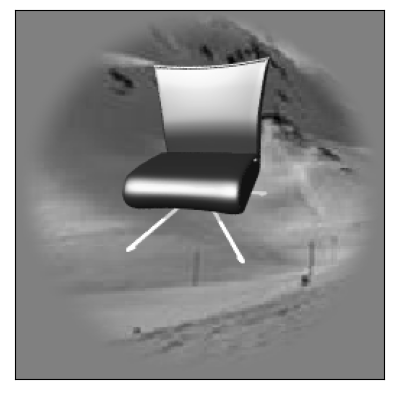

In [30]:
import os
import pandas as pd
import numpy as np
import xarray as xr
from PIL import Image
from matplotlib import pyplot as plt

def paths_from_dir(dir_path):
    image_paths = [os.path.join(dir_path, file) for file in os.listdir(dir_path)]
    return image_paths

def paths_from_csv(image_dir, csv_path, column):
    file_names = pd.read_csv(csv_path)[column].values.tolist()
    image_paths = [os.path.join(image_dir, file) for file in file_names]
    return image_paths

def images_from_dir(dir_path, return_da=False):
    images = np.stack([Image(i) for i in os.listdir(dir_path)])
    if return_da:
        images = xr.DataArray(data=images)
    return images

def images_from_path(image_paths, return_da=False):
    images = np.stack(Image.open(i) for i in image_paths)
    if return_da:
        images = xr.DataArray(data=images)
    return images

def load_single_image(image_paths, index):
    i = image_paths[index]
    print(i)
    image = np.asarray(Image.open(i))
    return image

imagenet = False
if imagenet:
    imagenet_dir = '/data/shared/.cache/brainscore/model-tools/imagenet2012.hdf5-files'
    imagenet_paths = paths_from_dir(imagenet_dir)
    imagenet_image = load_single_image(imagenet_paths, index=12040)
     # - index up to 12040-1
    #imagenet_images = images_from_dir(imagenet_dir)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenet_image)
    plt.show()
    #for rockfish check MT_HOME path (actually for any project)
    #'/data/keaton/model-tools/imagenet2012.hdf5-files'

majaj_hong = False
if majaj_hong:
    majaj_dir = '/data/shared/brainio/brain-score/dicarlo.hvm-public'
    majaj_csv = '/data/shared/brainio/brain-score/image_dicarlo_hvm-public.csv'
    majaj_column = 'image_file_name'
    majaj_paths = paths_from_csv(majaj_dir, majaj_csv, column=majaj_column)
    majaj_image = load_single_image(majaj_paths, index=1420)
    # - index up to 3200-1
    #on rockfish cannnot use images_from_dir for mjh images (csv file is in the directory), on server can use images_from_dir
    plt.xticks([])
    plt.yticks([])
    plt.imshow(majaj_image)
    plt.show()
    #rockfish = '/home/wtownle1/data-mbonner5/shared/brainio/bonner-datasets/image_dicarlo_hvm-public'
    #rockfish csv: '/home/wtownle1/data-mbonner5/shared/brainio/bonner-datasets/image_dicarlo_hvm-public/image_dicarlo_hvm-public.csv'

ilsvrc = True
if ilsvrc:
    train = True
    test = True
    #ilsvrc_val contains directories (ex: n03188531), didn't find a csv to parse them
    ilsvrc_root = '/data/shared/datasets/ilsvrc2012'
    ilsvrc_csv = '/data/shared/datasets/ilsvrc2012/ilsvrc2012.csv'
    # - csv links to only train images
    ilsvrc_test_dir = os.path.join(ilsvrc_root, 'test')
    if train:
        ilsvrc_train_paths = paths_from_csv(ilsvrc_root, ilsvrc_csv, column='filename')
        ilsvrc_train_image = load_single_image(ilsvrc_train_paths, index=0)
    if test:
        ilsvrc_test_paths = paths_from_dir(ilsvrc_test_dir)
        ilsvrc_test_image = load_single_image(ilsvrc_test_paths)